In [2]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [21]:
X_train_features_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/denoising-pneumonia/Feature_Extraction/try/X_train_features.npy"
X_val_features_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/denoising-pneumonia/Feature_Extraction/try/X_val_features.npy"
X_test_features_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/denoising-pneumonia/Feature_Extraction/try/X_test_features.npy"
y_train_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/denoising-pneumonia/Feature_Extraction/try/y_train.npy"
y_val_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/denoising-pneumonia/Feature_Extraction/try/y_val.npy"
y_test_dir = "/home/dawlat.akaila/Documents/AI_LABS/PROJECT_FINAL/denoising-pneumonia/Feature_Extraction/try/y_test.npy"

In [37]:
# load features
X_train_features = np.load(X_train_features_dir)
X_val_features = np.load(X_val_features_dir)
X_test_features = np.load(X_test_features_dir)

y_train = np.load(y_train_dir)
y_val = np.load(y_val_dir)
y_test = np.load(y_test_dir)

In [38]:
# Define classifier
logreg_model = LogisticRegression()

In [39]:
# Make predictions on the val set
logreg_model.fit(X_train_features, y_train)
y_pred_val = logreg_model.predict(X_val_features)

# Evaluate the model on the test set
accuracy_val = sklearn.metrics.accuracy_score(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f'Mean Squared Error: {mse:.2f}')

Validation Accuracy: 0.4375
Mean Squared Error: 0.56


/home/dawlat.akaila/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# Make predictions on the test set
logreg_model.fit(X_train_features, y_train)
y_pred_test = logreg_model.predict(X_test_features)

# Evaluate the model on the test set
accuracy_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f'Mean Squared Error: {mse:.2f}')

Test Accuracy: 0.38782051282051283
Mean Squared Error: 0.61


/home/dawlat.akaila/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### LDA

In [6]:
# Standardize the features (important for LDA)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_features)
X_val_std = scaler.fit_transform(X_val_features)
X_test_std = scaler.fit_transform(X_test_features)

In [18]:
lda = LinearDiscriminantAnalysis(n_components=1)  # Set the desired number of components
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_val_lda = lda.transform(X_val_std)
X_test_lda = lda.transform(X_test_std)

In [20]:
# Make predictions on the val set
logreg_model.fit(X_train_lda, y_train)
y_pred_val = logreg_model.predict(X_val_lda)

# Evaluate the model on the test set
accuracy_val = sklearn.metrics.accuracy_score(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f'Mean Squared Error: {mse:.2f}')

Validation Accuracy: 0.5
Mean Squared Error: 0.50


In [21]:
# Make predictions on the test set
y_pred_test = logreg_model.predict(X_test_lda)

# Evaluate the model on the test set
accuracy_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f'Mean Squared Error: {mse:.2f}')

Test Accuracy: 0.5817307692307693
Mean Squared Error: 0.42


### PCA

In [34]:
scaled_X_train = scaler.fit_transform(X_train_features)

n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(scaled_X_train)

print(X_train_pca.shape)

(5216, 100)


In [23]:
scaled_X_val = scaler.fit_transform(X_val_features)

n_components = 16
pca = PCA(n_components=n_components)
X_val_pca = pca.fit_transform(scaled_X_val)

print(X_val_pca.shape)

(16, 16)


In [35]:
scaled_X_test = scaler.fit_transform(X_test_features)

n_components = 100
pca = PCA(n_components=n_components)
X_test_pca = pca.fit_transform(scaled_X_test)

print(X_test_pca.shape)

(624, 100)


In [25]:
# Make predictions on the val set
logreg_model.fit(X_train_pca, y_train)
y_pred_val = logreg_model.predict(X_val_pca)

# Evaluate the model on the test set
accuracy_val = sklearn.metrics.accuracy_score(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f'Mean Squared Error: {mse:.2f}')

Validation Accuracy: 0.4375
Mean Squared Error: 0.56


In [36]:
# Make predictions on the test set
logreg_model.fit(X_train_pca, y_train)
y_pred_test = logreg_model.predict(X_test_pca)

# Evaluate the model on the test set
accuracy_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f'Mean Squared Error: {mse:.2f}')

Test Accuracy: 0.5913461538461539
Mean Squared Error: 0.41


### T-SNE

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Assuming X_train, X_val, and X_test are your training, validation, and test sets

# Create a scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.fit_transform(X_val_features)
X_test_scaled = scaler.fit_transform(X_test_features)

# Apply t-SNE to reduce the dimensionality to 2D for scaled data
tsne = TSNE(n_components=2,perplexity=5)

X_train_tsne = tsne.fit_transform(X_train_scaled)
X_val_tsne = tsne.fit_transform(X_val_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)

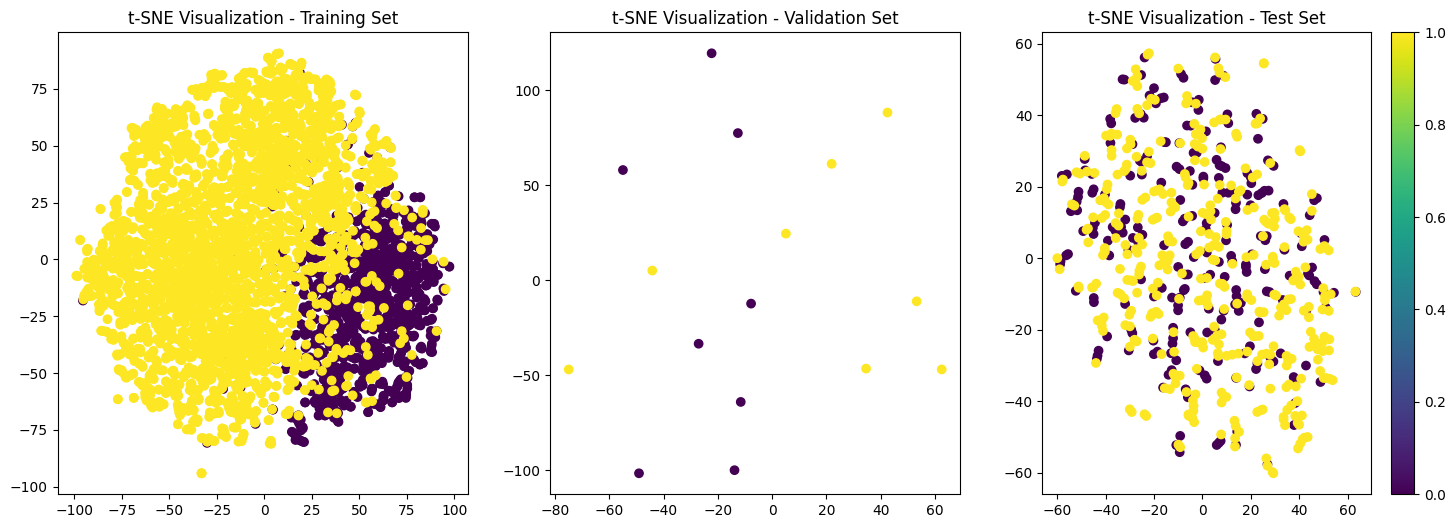

In [28]:
# Create scatter plots for training, validation, and test sets
# (similar to the previous example)
# Create scatter plots for training, validation, and test sets
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')
plt.title('t-SNE Visualization - Training Set')

plt.subplot(1, 3, 2)
plt.scatter(X_val_tsne[:, 0], X_val_tsne[:, 1], c=y_val, cmap='viridis')
plt.title('t-SNE Visualization - Validation Set')

plt.subplot(1, 3, 3)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='viridis')
plt.title('t-SNE Visualization - Test Set')

plt.colorbar()
plt.show()

In [29]:
# Make predictions on the test set
logreg_model.fit(X_train_tsne, y_train)
y_pred_test = logreg_model.predict(X_test_tsne)

# Evaluate the model on the test set
accuracy_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f'Mean Squared Error: {mse:.2f}')

Test Accuracy: 0.5384615384615384
Mean Squared Error: 0.46
